In [123]:
import pprint

import pandas as pd
from matplotlib import pyplot as plt

airlines_passengers = pd.read_csv("../ts_hw_1/Series/international-airline-passengers.csv")
female_births = pd.read_csv("../ts_hw_1/Series/daily-total-female-births-in-cal.csv")

In [124]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"]
}

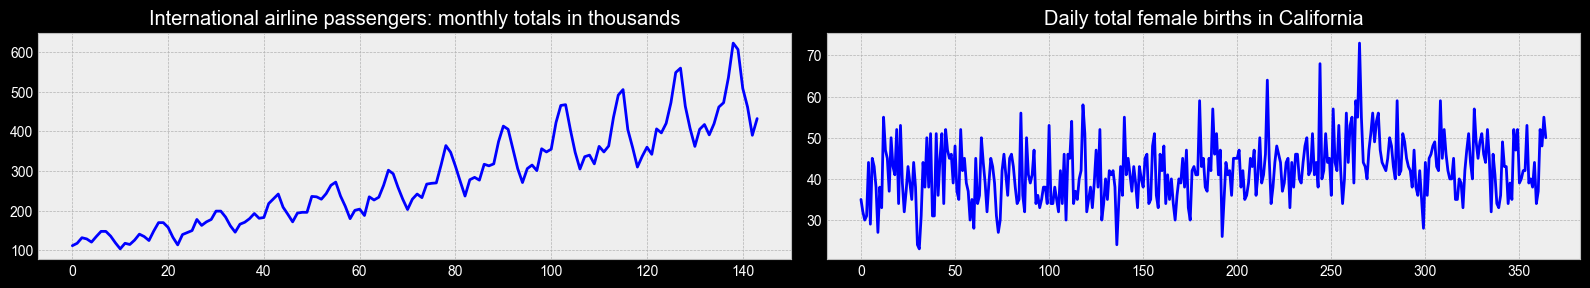

In [125]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [126]:
def ma_model(series, window):
    ma = series.rolling(window=window).mean()
    return ma.iloc[-1]

def ema_model(series, window):
    ema = series.ewm(span=window, adjust=False).mean()
    return ema.iloc[-1]

def dema_model(series, window):
    ema_1 = series.ewm(span=window, adjust=False).mean()
    ema_2 = ema_1.ewm(span=window, adjust=False).mean()
    dema = 2 * ema_1 - ema_2
    return dema.iloc[-1]

def tema_model(series, window):
    ema_1 = series.ewm(span=window, adjust=False).mean()
    ema_2 = ema_1.ewm(span=window, adjust=False).mean()
    ema_3 = ema_2.ewm(span=window, adjust=False).mean()
    tema = 3 * ema_1 - 3 * ema_2 + ema_3
    return tema.iloc[-1]

tema_model(airlines_passengers["Count"], 2)


427.0040697070564

In [127]:
models = {
    "MA": ma_model,
    "EMA": ema_model,
    "DEMA": dema_model,
    "TEMA": tema_model,
}

In [128]:
def evaluate_model(series, model, window_range=range(2, 31)):
    train = series[:-1]
    true_val = series.iloc[-1]
    best_mae = float('inf')
    best_window = None
    best_fcst = None

    for i in window_range:
        fcst = model(train, i)
        if pd.isna(fcst):
            continue
        mae = abs(true_val - fcst)
        if mae < best_mae:
            best_mae = mae
            best_window = i
            best_fcst = fcst

    return best_mae, best_window, best_fcst

In [129]:
res = {}

for name, series in [("Nonstat_Airline", airlines_passengers["Count"]), ("Stat_Births", female_births["Count"])]:
    res[name] = {}
    for model_name, model_func in models.items():
        mae, window, pred = evaluate_model(series, model_func)
        res[name][model_name] = {"MAE": mae.round(2), "best_window": window, "prediction": pred.round(2)}

pprint.pp(res)

{'Nonstat_Airline': {'MA': {'MAE': 6.22,
                            'best_window': 27,
                            'prediction': 438.22},
                     'EMA': {'MAE': 9.74,
                             'best_window': 2,
                             'prediction': 422.26},
                     'DEMA': {'MAE': 5.32,
                              'best_window': 4,
                              'prediction': 426.68},
                     'TEMA': {'MAE': 4.21,
                              'best_window': 6,
                              'prediction': 427.79}},
 'Stat_Births': {'MA': {'MAE': 1.5, 'best_window': 2, 'prediction': 51.5},
                 'EMA': {'MAE': 0.68, 'best_window': 3, 'prediction': 50.68},
                 'DEMA': {'MAE': 0.01, 'best_window': 7, 'prediction': 50.01},
                 'TEMA': {'MAE': 0.24, 'best_window': 11, 'prediction': 49.76}}}


1) Nonstat_Airline - лучшая модель для прогноза последнего значения TEMA - что ожидаемо, так как ряд имеет сильный восходящий тренд и явную сезонность

2) Stat_Births - лучшая модель для прогноза последнего значения DEMA - что не очень ожидаемо, но так как подобрано лучшее окно для сгаживания, то шум удалось погасить